In [1]:
import matplotlib.pyplot as plt
import corner as corner
import pandas as pd
import numpy as np
import h5py
import torch
import time
from scipy.special import logsumexp
from functools import reduce
import operator
from copy import deepcopy

import sys

sys.path.append('../')
from populations.bbh_models import get_models
import populations.bbh_models as read_models
from populations.utils.flow import NFlow
from populations.Flowsclass_dev import FlowModel
from populations import gw_obs
from populations.bbh_models import read_hdf5

from sample import sample as samp

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [2]:
param = ['mchirp','q', 'chieff', 'z']
param_label = ['Chirp Mass /$M_{\odot}$','Mass Ratio', 'Effective Spin', 'Redshift']

no_params = len(param)
channel_label = ['CE', 'CHE','GC','NSC', 'SMT']

models_path ='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'

In [3]:
params = ['mchirp','q', 'chieff', 'z']
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gw_events'
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', None)

model_names, flow = read_models.get_models(file_path, channel_label, params, use_flows=True, device='cpu', no_bins=[5,4,4,5,4], use_unityweights=False)
_, KDE = read_models.get_models(file_path, channel_label, params, use_flows=False, device='cpu', use_unityweights=False)

100%|██████████| 36/36 [00:13<00:00,  2.68it/s]


In [5]:
#inputs: x, data, pop_models, submodels_dict, channels, use_flows
channels = sorted(list(set([x.split('/')[0] for x in model_names])))
model_names.sort()
hyperparams = sorted(list(set([x.split('/', 1)[1] for x in model_names])))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])

hyperparam_dict  = {}
hyperidx=0
while hyperidx < Nhyper:
    hyperidx_with_Nhyper = np.argwhere(np.asarray([len(x.split('/')) for x in hyperparams])>hyperidx).flatten()
    hyperparams_at_level = sorted(set([x.split('/')[hyperidx] for x in np.asarray(hyperparams)[hyperidx_with_Nhyper]]))
    hyperparam_dict[hyperidx] = hyperparams_at_level
    hyperidx += 1


# ---  Copy kde_models so that they all have the same levels of hyperparameters
def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)
def setInDict(dataDict, mapList, value):
    getFromDict(dataDict, mapList[:-1])[mapList[-1]] = value
    
all_models_at_deepest = all([len(x.split('/')[1:])==Nhyper for x in model_names])
while all_models_at_deepest==False:
    # loop until all models have the same length
    for model in model_names:
        # See number of hyperparameters in model, subtract one for channel
        Nhyper_in_model = len(model.split('/'))-1
        kde_hold = getFromDict(KDE, model.split('/'))
        # loop until this model has all the hyperparam levels as well
        print(Nhyper_in_model)
        while Nhyper_in_model < Nhyper:
            # remove kde model from old level
            setInDict(KDE, model.split('/'), {})
            model_names.remove(model)
            for new_hyperparam in hyperparam_dict[Nhyper_in_model]:
                # copy the same kde model for the higher hyperparam level
                new_kde = deepcopy(kde_hold)
                new_level = model.split('/') + [new_hyperparam]
                setInDict(KDE, new_level, new_kde)
                print(new_level)
                # add new model name
                model_names.append(model+'/'+new_hyperparam)
            Nhyper_in_model += 1
        model_names.sort()
    # see if all models are at deepest level else repeat
    all_models_at_deepest = all([len(x.split('/')[1:])==Nhyper for x in model_names])


In [6]:

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [7]:
flow_path="/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_230124_100000epochs/flow_models/"
for i, channel in enumerate(channel_label):
    flow[channel].load_model(flow_path, channel)

## 2D over mchirp-q

In [56]:
mchirps = np.linspace(0.1,49.9,20)
qs = np.linspace(0.01,0.99,20)

p_mchirpq = np.zeros((4,5,20,20))
p_mchirpq_kde = np.zeros((4,5,20,20))

chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        for  i, m in enumerate(mchirps):
            for j, q in enumerate(qs):
                sample = np.reshape([m, q,0.0,0.2], (1,1,4))
                p_mchirpq[chibid, alphaid, i, j] = samp.lnlike([xb,a,0.5,0.05,0.2,0.1], sample, flow, submodels_dict, channels, use_flows=True, prior_pdf=None, use_reg=True, smallest_n=9909)
                p_mchirpq_kde[chibid, alphaid, i, j] = samp.lnlike([chibid,alphaid,0.5,0.05,0.2,0.1], sample, KDE, submodels_dict, channels, use_flows=False, prior_pdf=None,use_reg=True, smallest_n=9909)
        print(xb,a)

[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00011657]
[0.00010091]
[0.0001013]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010985]
[0.0001011]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010694]
[0.0001014]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010197]
[0.00010121]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010093]
[0.00010139]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010149]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010551]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010313]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010242]
[0.00010091]
[0

In [51]:
chi_b = [0.0]
alpha = [0.2]

flow_likelihood = np.zeros((20,20))
kde_likelihood = np.zeros((20,20))

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        for  i, m in enumerate(mchirps):
            for j, q in enumerate(qs):
                sample = np.reshape([m, q,0.0,0.2], (1,1,4))
                flow_likelihood[i, j] = samp.lnlike([xb,a,0.5,0.05,0.2,0.1], sample, flow, submodels_dict, channels, use_flows=True, prior_pdf=None, use_reg=True, smallest_n=9909)
                kde_likelihood[i, j] = samp.lnlike([chibid,alphaid, 0.5,0.05,0.2,0.1], sample, KDE, submodels_dict, channels, use_flows=False, prior_pdf=None,use_reg=True, smallest_n=9909)


[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00011657]
[0.00010091]
[0.0001013]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010985]
[0.0001011]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010694]
[0.0001014]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010197]
[0.00010121]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010093]
[0.00010139]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010149]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010551]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010313]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010242]
[0.00010091]
[0

In [17]:
np.save('llh_ratio/slices/allchannels2Dmchirpq_chi0_z02_p_flow_9909smallestn.npy', p_mchirpq, allow_pickle=True)
np.save('llh_ratio/slices/allchannels2Dmchirpq_chi0_z02_p_KDE_9909smallestn.npy', p_mchirpq_kde, allow_pickle=True)

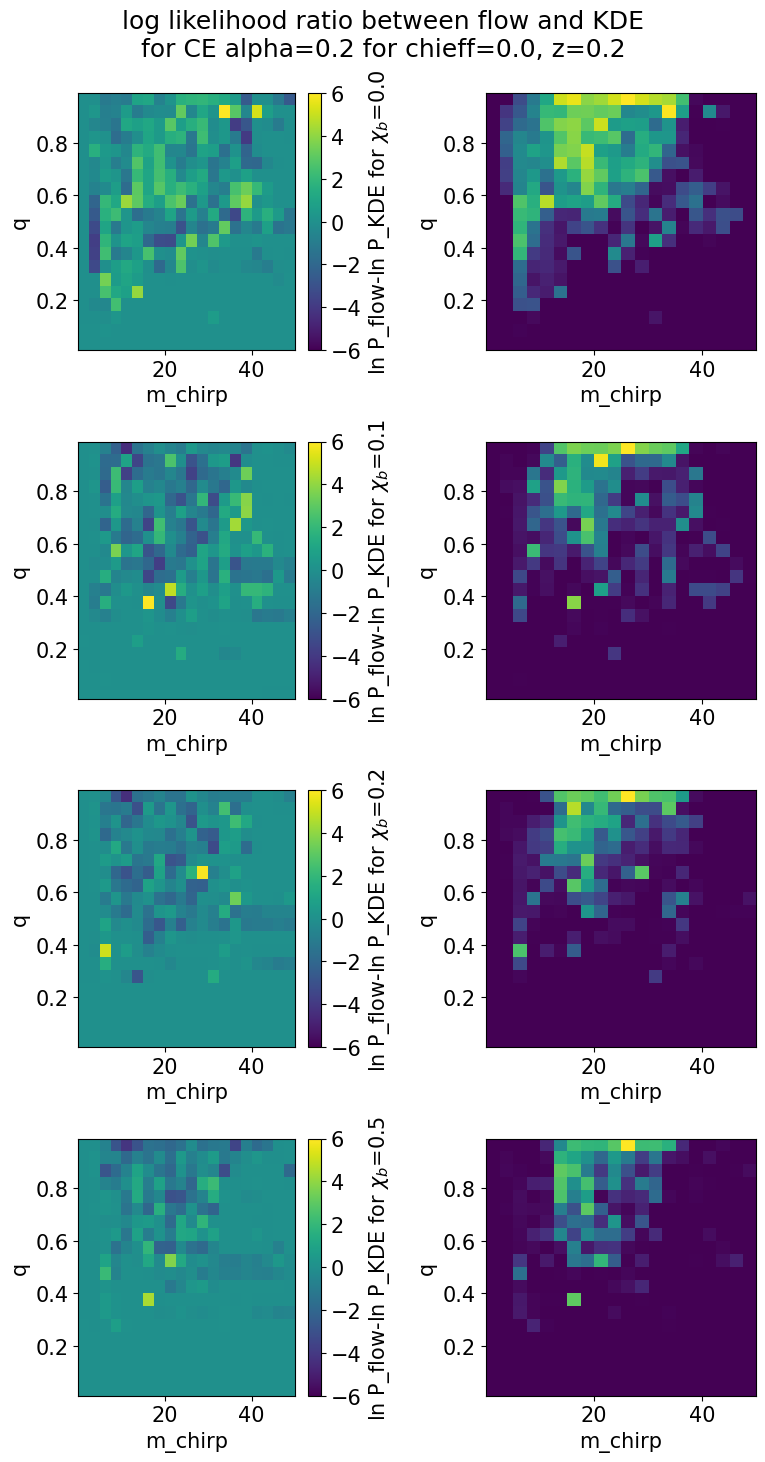

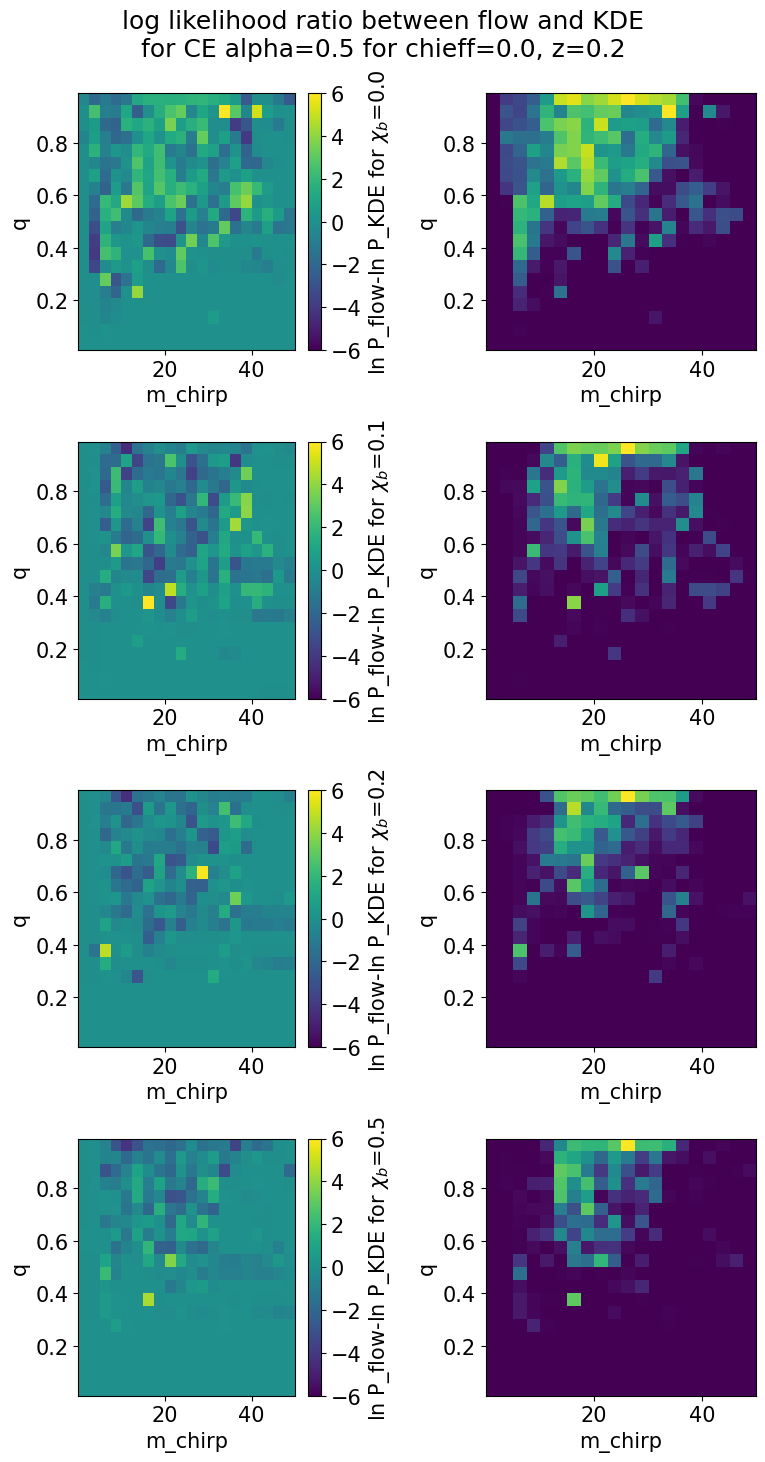

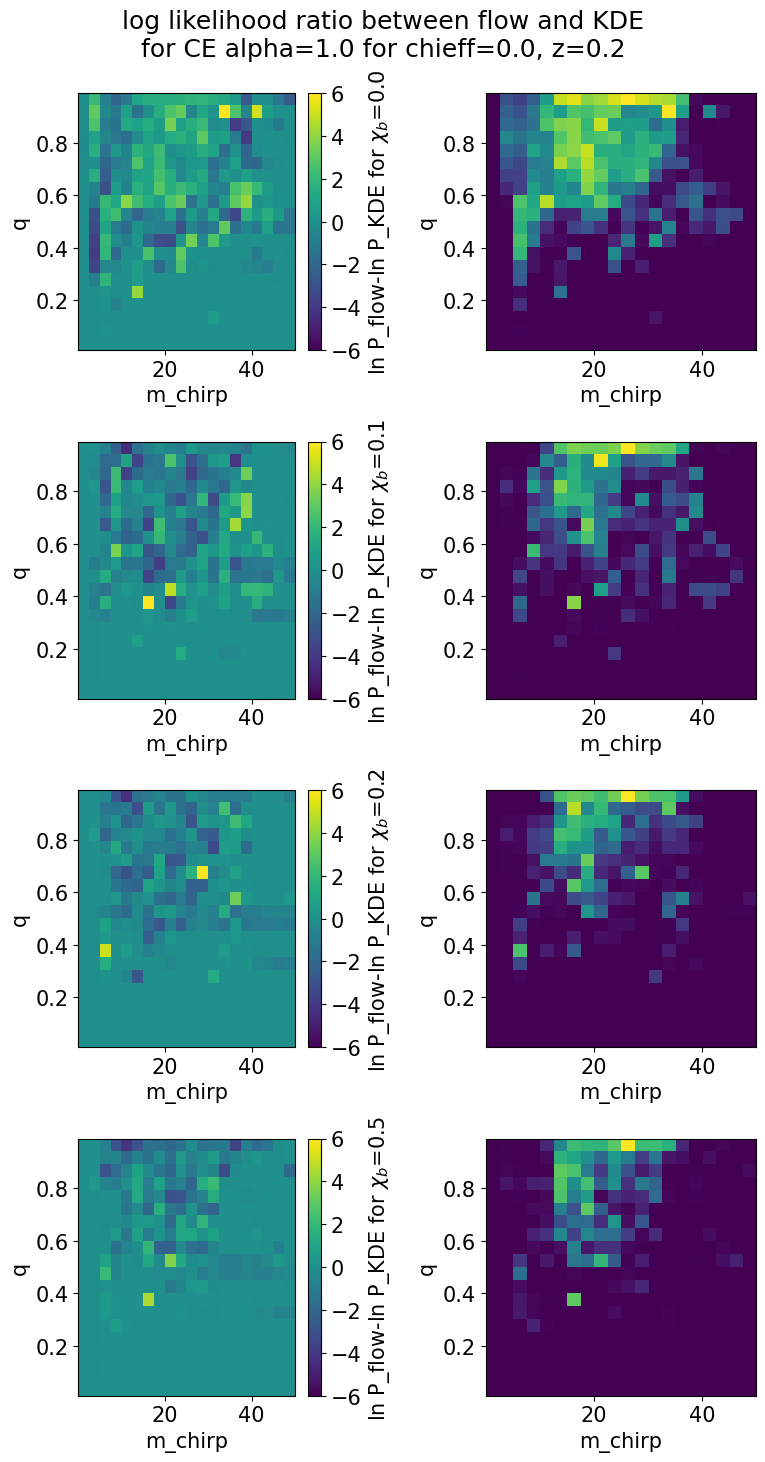

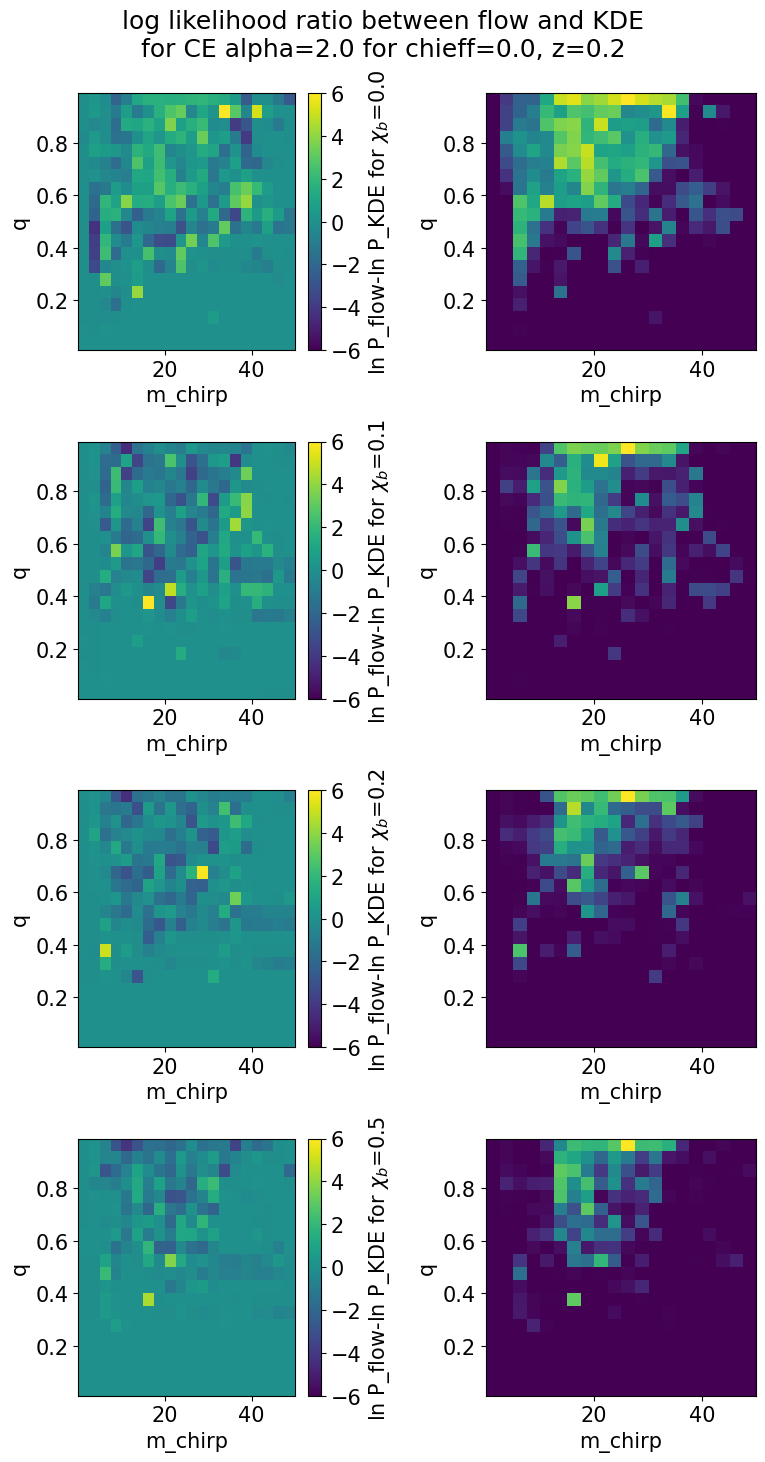

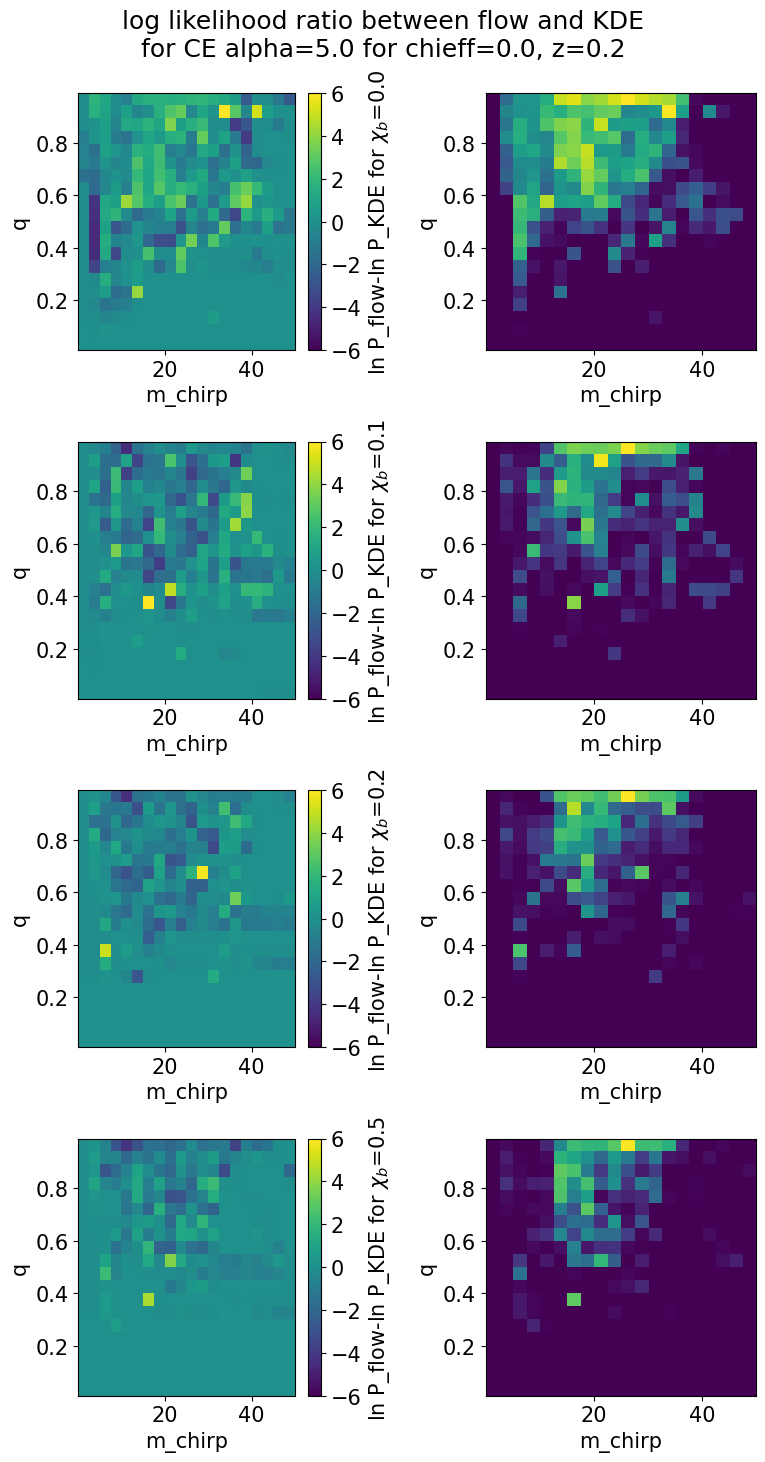

In [59]:
plt.rcParams["figure.figsize"] = (8,15)
plt.rcParams.update({'font.size': 15})

for alphaid in range(5):
    fig, ax = plt.subplots(4,2)
    for chibid in range(4):
        ratio = p_mchirpq[chibid, alphaid,:,:]-p_mchirpq_kde[chibid, alphaid,:,:]
        #oldratio = strict_reg_flow[chibid, alphaid,:,:]-strct_reg_KDE[chibid, alphaid,:,:]
        c = ax[chibid,0].imshow(np.swapaxes(ratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto')
        ax[chibid,1].imshow(np.swapaxes(p_mchirpq[chibid, alphaid,:,:], 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', aspect='auto')

        cbar = fig.colorbar(c, ax=ax[chibid,0])
        cbar.set_label(fr'ln P_flow-ln P_KDE for $\chi_b$={chi_b[chibid]}')
        #c = ax[chibid,1].imshow(np.swapaxes(oldratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto')


        ax[chibid,0].set_xlabel(fr'm_chirp')
        ax[chibid,1].set_xlabel(fr'm_chirp')
        ax[chibid,0].set_ylabel(fr'q')

        """ bin_width = 0.05
        chieffs = models_dict[(chibid,alphaid)][:]['chieff']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_chieff = np.logical_and(chieffs>0.0 - 2*bin_width,  chieffs< 0.0 + 2*bin_width)
        bin_z = np.logical_and(zs>0.2 - 10*bin_width, zs < 0.2 + 10*bin_width)
        bin_conditions = np.logical_and(bin_chieff, bin_z)

        c = ax[chibid,1].imshow(np.swapaxes(ratio,0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto', zorder=-200)

        corner.hist2d(np.array(models_dict[(chibid,alphaid)][bin_conditions]['mchirp']), np.array(models_dict[(chibid,alphaid)][bin_conditions]['q']),\
             weights=np.array(weights_dict[(chibid,alphaid)][bin_conditions]), alpha=0.5, density=True, ax=ax[chibid,1], no_fill_contours=True)
        """
        ax[chibid,1].set_xlim(mchirps[0], mchirps[-1])
        ax[chibid,1].set_ylim(qs[0], qs[-1])
        ax[chibid,1].set_xlabel(fr'm_chirp')
        ax[chibid,1].set_ylabel(fr'q')
    fig.suptitle('log likelihood ratio between flow and KDE''\n'fr'for CE alpha={alpha[alphaid]} for chieff=0.0, z=0.2')
    fig.tight_layout(pad=1.3)
    #fig.savefig(f'llh_ratio/slices/CE2Dmchirpq_chi0_z02_alpha{alpha[alphaid]}.pdf')

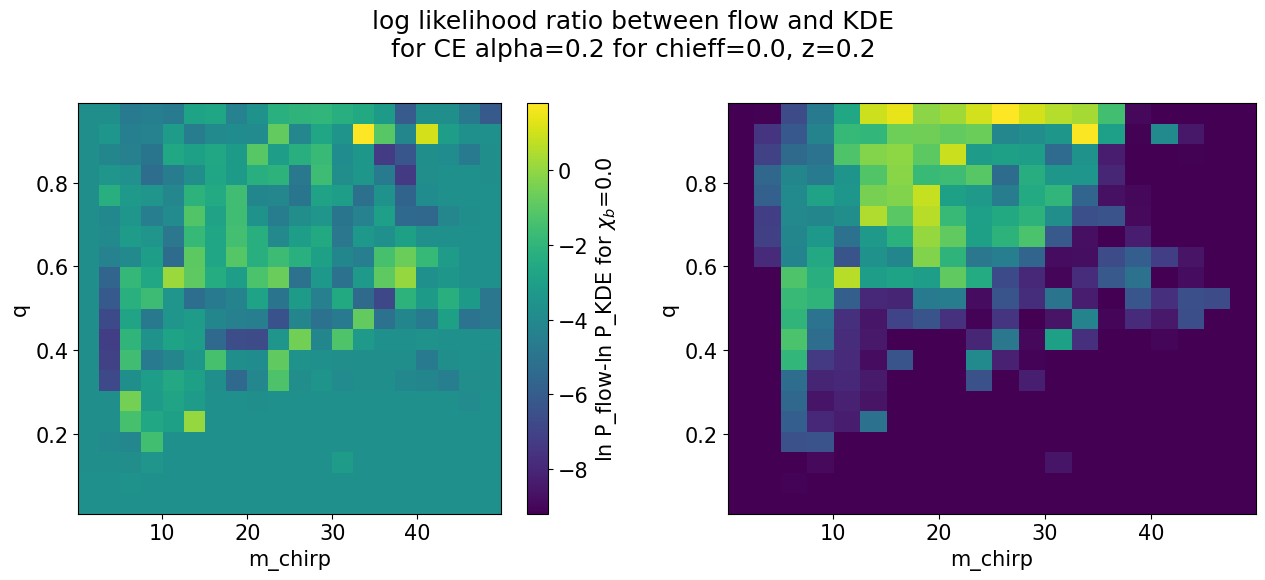

In [55]:
plt.rcParams["figure.figsize"] = (13,6)
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1,2)
ratio = flow_likelihood[:,:]-kde_likelihood[:,:]
#oldratio = strict_reg_flow[chibid, alphaid,:,:]-strct_reg_KDE[chibid, alphaid,:,:]
c = ax[0].imshow(np.swapaxes(ratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto')
c = ax[1].imshow(np.swapaxes(flow_likelihood, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', aspect='auto')

cbar = fig.colorbar(c, ax=ax[0])
cbar.set_label(fr'ln P_flow-ln P_KDE for $\chi_b$={chi_b[chibid]}')
#c = ax[chibid,1].imshow(np.swapaxes(oldratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto')


ax[0].set_xlabel(fr'm_chirp')
ax[1].set_xlabel(fr'm_chirp')
ax[0].set_ylabel(fr'q')

""" bin_width = 0.05
chieffs = models_dict[(chibid,alphaid)][:]['chieff']
zs = models_dict[(chibid,alphaid)][:]['z']
bin_chieff = np.logical_and(chieffs>0.0 - 2*bin_width,  chieffs< 0.0 + 2*bin_width)
bin_z = np.logical_and(zs>0.2 - 10*bin_width, zs < 0.2 + 10*bin_width)
bin_conditions = np.logical_and(bin_chieff, bin_z)

c = ax[chibid,1].imshow(np.swapaxes(ratio,0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto', zorder=-200)

corner.hist2d(np.array(models_dict[(chibid,alphaid)][bin_conditions]['mchirp']), np.array(models_dict[(chibid,alphaid)][bin_conditions]['q']),\
        weights=np.array(weights_dict[(chibid,alphaid)][bin_conditions]), alpha=0.5, density=True, ax=ax[chibid,1], no_fill_contours=True)
"""
ax[1].set_xlim(mchirps[0], mchirps[-1])
ax[1].set_ylim(qs[0], qs[-1])
ax[1].set_xlabel(fr'm_chirp')
ax[1].set_ylabel(fr'q')
fig.suptitle('log likelihood ratio between flow and KDE''\n'fr'for CE alpha={alpha[alphaid]} for chieff=0.0, z=0.2')
fig.tight_layout(pad=1.3)
#fig.savefig(f'llh_ratio/slices/CE2Dmchirpq_chi0_z02_alpha{alpha[alphaid]}.pdf')

In [43]:
likelihood=np.ones(100)
smallest_N=1000
#population probability plus uniform regularisation
pi_reg = 1/(smallest_N+1)
q_weight = smallest_N/(smallest_N+1)
likelihood = (q_weight * likelihood) + pi_reg
likelihood

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## 4D plot of ratio

In [7]:
mchirps = np.linspace(0.1,65.,10)
qs = np.linspace(0.01,0.99,10)
chieffs = np.linspace(-0.5,0.99,10)
zs = np.linspace(0.01,6.,10)

In [41]:
p_mchirpqchiz = np.zeros((4,10,10,10,10))
p_mchirpqchiz_kde = np.zeros((4,10,10,10,10))

chi_b=[0.,0.1]
alphaCEid = 4
for chibid, xb in enumerate(chi_b):
    for  i, m in enumerate(mchirps):
        for j, q in enumerate(qs):
            for  x, chi in enumerate(chieffs):
                for y, z in enumerate(zs):
                    sample = np.reshape([m, q, chi, z], (1,1,4))
                    p_mchirpqchiz[chibid, i, j, x, y] = samp.lnlike([xb, alpha[alphaCEid], 0.5,0.05,0.2,0.1], sample, flow, submodels_dict, channels, use_flows=True, prior_pdf=None, smallest_N=990903)
                    p_mchirpqchiz_kde[chibid, i, j, x, y] = samp.lnlike([chibid, alphaCEid,0.5,0.05,0.2,0.1], sample, KDE, submodels_dict, channels, use_flows=False, prior_pdf=None, smallest_N=990903)

/Users/stormcolloms/opt/anaconda3/envs/amaze/lib/python3.9/site-packages/scipy/_lib/_util.py:287: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = toarray(a)


ValueError: object arrays are not supported

In [9]:
#np.save('llh_ratio/slices/allchannels4Dllh_flows_150124_smallestN990903.pdf', p_mchirpqchiz)
#np.save('llh_ratio/slices/allchannels4Dllh_KDEs_smallestN990903.pdf', p_mchirpqchiz_kde)


ValueError: x and y must have same first dimension, but have shapes (10,) and (4, 10)

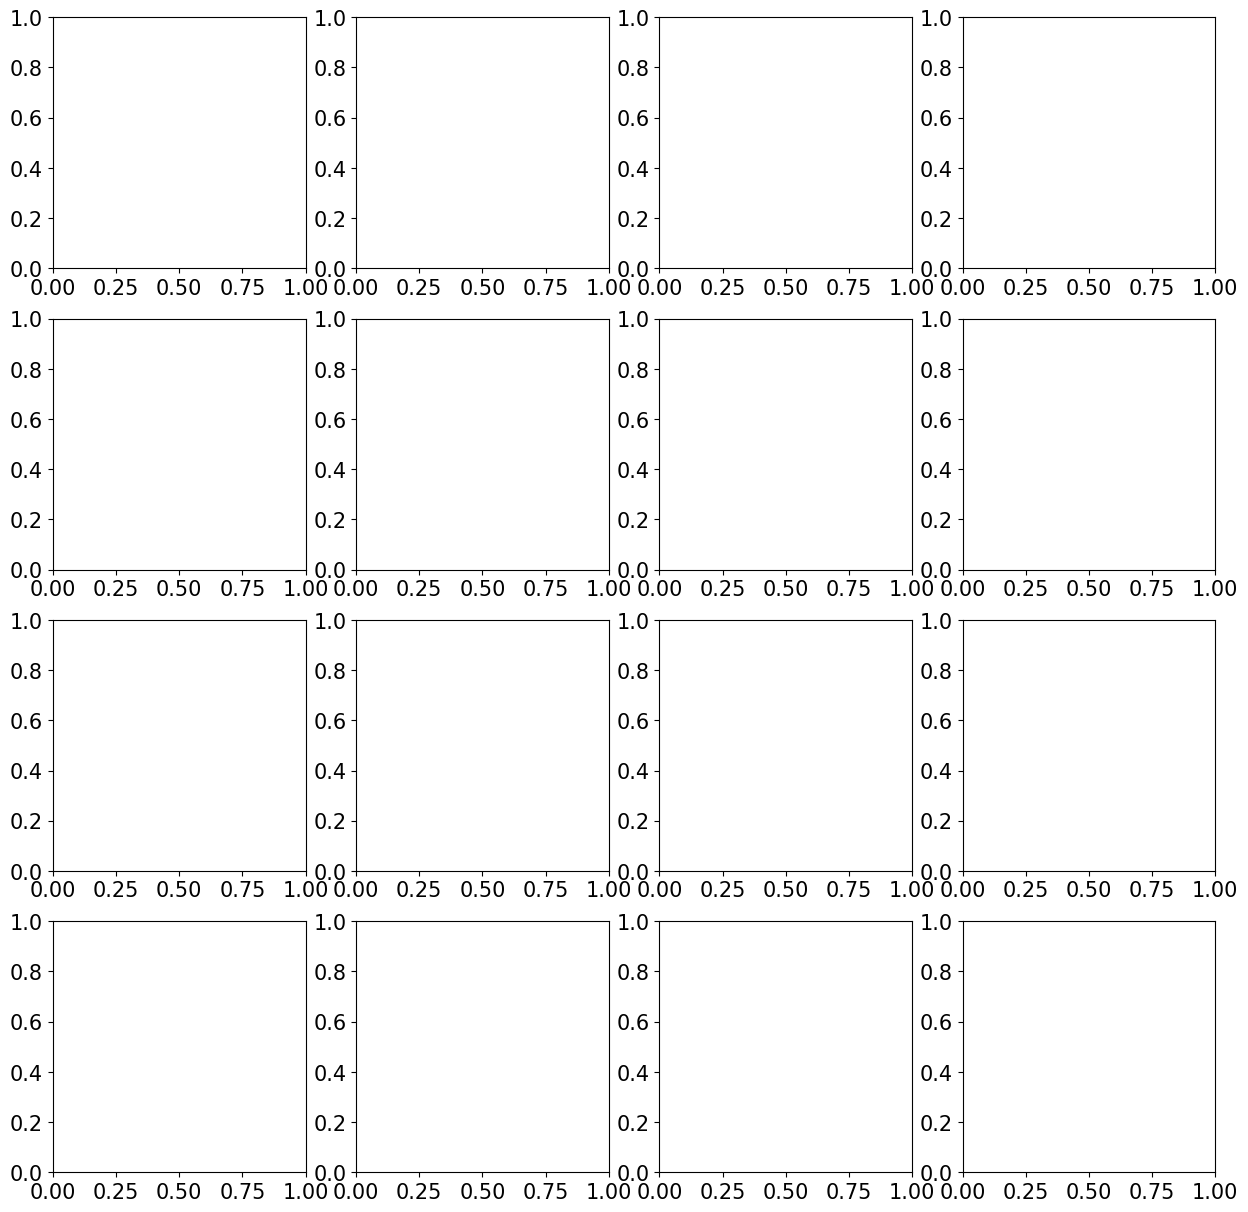

In [12]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig,ax=plt.subplots(4,4)
chibid = 0

ratio_mchirpq_marg = np.sum(p_mchirpqchiz, axis=(3,4)) - np.sum(p_mchirpqchiz_kde, axis=(3,4))
ratio_mchirpchieff_marg = np.sum(p_mchirpqchiz, axis=(2,4)) - np.sum(p_mchirpqchiz_kde, axis=(2,4))
ratio_qchieff_marg = np.sum(p_mchirpqchiz, axis=(1,4)) - np.sum(p_mchirpqchiz_kde, axis=(1,4))
ratio_mchirpz_marg = np.sum(p_mchirpqchiz, axis=(2,3)) - np.sum(p_mchirpqchiz_kde, axis=(2,3))
ratio_qz_marg = np.sum(p_mchirpqchiz, axis=(1,3)) - np.sum(p_mchirpqchiz_kde, axis=(1,3))
ratio_chieffz_marg = np.sum(p_mchirpqchiz, axis=(1,2)) - np.sum(p_mchirpqchiz_kde, axis=(1,2))
ax[0,0].plot(mchirps, [np.sum(p_mchirpqchiz, axis=(2,3,4)) - np.sum(p_mchirpqchiz_kde, axis=(2,3,4))][0][0])
ax[0,0].set_xlabel('mchirp')
ax[1,1].plot(qs, [np.sum(p_mchirpqchiz, axis=(1,3,4)) - np.sum(p_mchirpqchiz_kde, axis=(1,3,4))][0][0])
ax[1,1].set_xlabel('q')
ax[2,2].plot(chieffs, [np.sum(p_mchirpqchiz, axis=(1,2,4)) - np.sum(p_mchirpqchiz_kde, axis=(1,2,4))][0][0])
ax[2,2].set_xlabel('chieff')
ax[3,3].plot(zs, [np.sum(p_mchirpqchiz, axis=(1,2,3)) - np.sum(p_mchirpqchiz_kde, axis=(1,2,3))][0][0])
ax[3,3].set_xlabel('zs')

ax[0,1].set_axis_off()
ax[0,2].set_axis_off()
ax[1,2].set_axis_off()
ax[0,3].set_axis_off()
ax[1,3].set_axis_off()
ax[2,3].set_axis_off()

cbarmin=200

c = ax[1,0].imshow(np.swapaxes(ratio_mchirpq_marg[0], 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[2,0].imshow(np.swapaxes(ratio_mchirpchieff_marg[0], 0,1), extent=(mchirps[0], mchirps[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[2,1].imshow(np.swapaxes(ratio_qchieff_marg[0], 0,1), extent=(qs[0], qs[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,0].imshow(np.swapaxes(ratio_mchirpz_marg[0], 0,1), extent=(mchirps[0], mchirps[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[3,1].imshow(np.swapaxes(ratio_qz_marg[0], 0,1), extent=(qs[0], qs[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,2].imshow(np.swapaxes(ratio_chieffz_marg[0], 0,1), extent=(chieffs[0], chieffs[-1], zs[0], zs[-1], ), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')


fig.tight_layout(pad=1.3)

#cbar = fig.colorbar(c, ax=ax[1,0])

ValueError: operands could not be broadcast together with shapes (5,10,10,10) (5,4,10,10) 

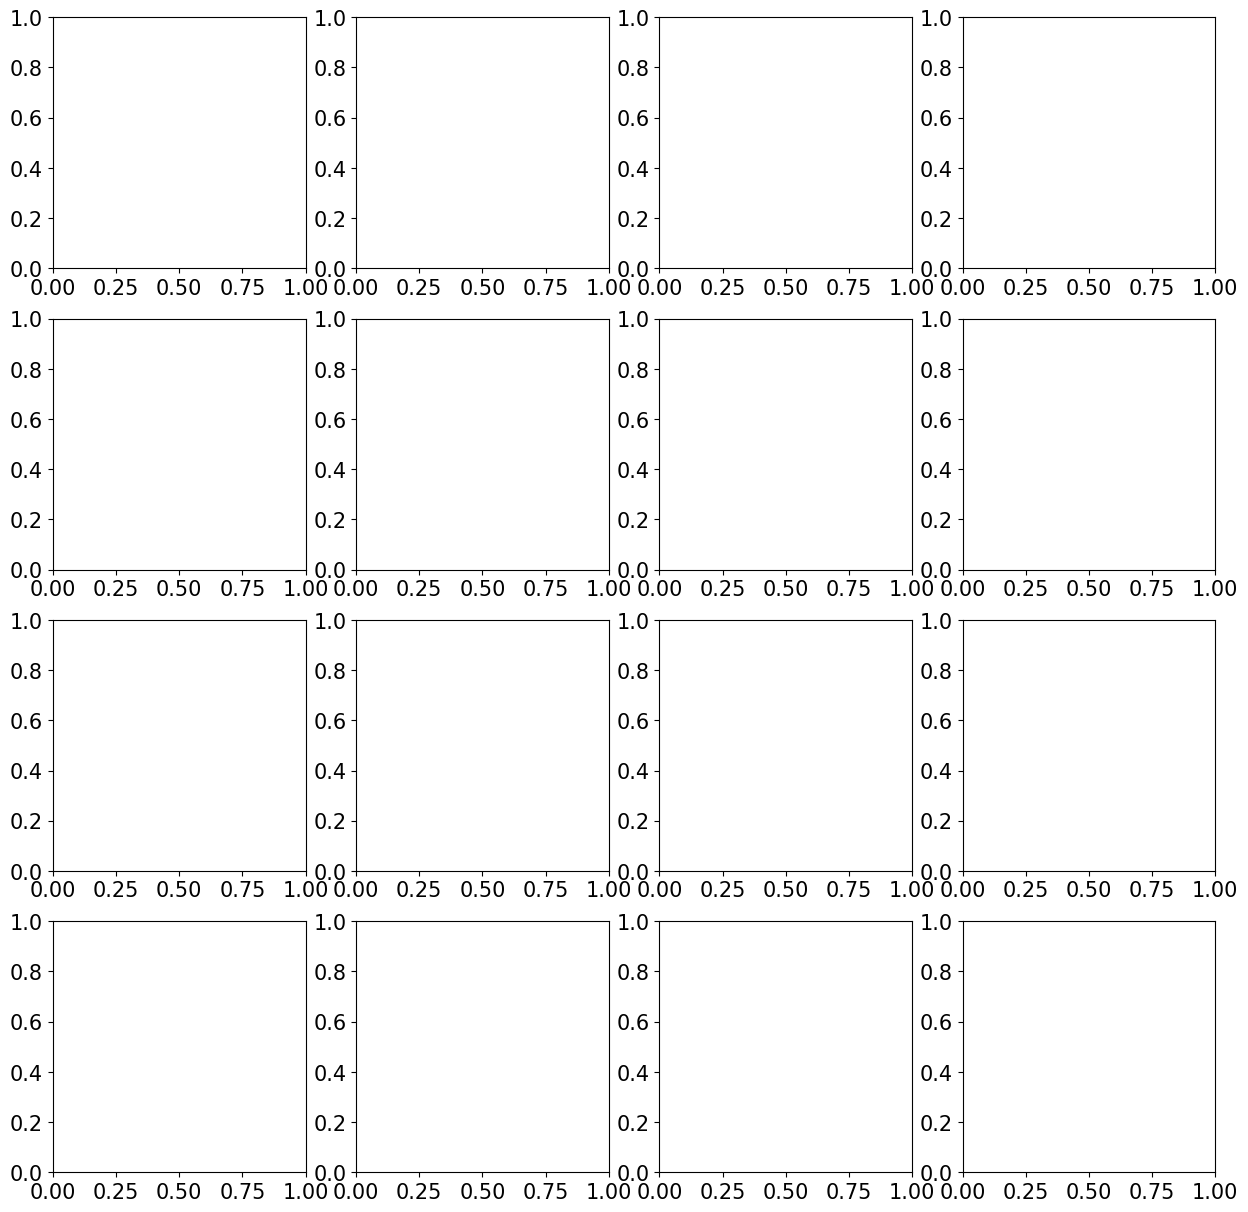

In [11]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig,ax=plt.subplots(4,4)
chibid = 1

ratio_mchirpq_marg = np.sum(p_mchirpqchiz, axis=(3,4)) - np.sum(p_mchirpqchiz_kde, axis=(3,4))
ratio_mchirpchieff_marg = np.sum(p_mchirpqchiz, axis=(2,4)) - np.sum(p_mchirpqchiz_kde, axis=(2,4))
ratio_qchieff_marg = np.sum(p_mchirpqchiz, axis=(2,4)) - np.sum(p_mchirpqchiz_kde, axis=(2,4))
ratio_mchirpz_marg = np.sum(p_mchirpqchiz, axis=(2,3)) - np.sum(p_mchirpqchiz_kde, axis=(2,3))
ratio_qz_marg = np.sum(p_mchirpqchiz, axis=(1,3)) - np.sum(p_mchirpqchiz_kde, axis=(1,3))
ratio_chieffz_marg = np.sum(p_mchirpqchiz, axis=(1,2)) - np.sum(p_mchirpqchiz_kde, axis=(1,2))
ax[0,0].plot(mchirps, [np.sum(p_mchirpqchiz, axis=(2,3,4)) - np.sum(p_mchirpqchiz_kde, axis=(2,3,4))][0][chibid])
ax[0,0].set_xlabel('mchirp')
ax[1,1].plot(qs, [np.sum(p_mchirpqchiz, axis=(1,3,4)) - np.sum(p_mchirpqchiz_kde, axis=(1,3,4))][0][chibid])
ax[1,1].set_xlabel('q')
ax[2,2].plot(chieffs, [np.sum(p_mchirpqchiz, axis=(1,2,4)) - np.sum(p_mchirpqchiz_kde, axis=(1,2,4))][0][chibid])
ax[2,2].set_xlabel('chieff')
ax[3,3].plot(zs, [np.sum(p_mchirpqchiz, axis=(1,2,3)) - np.sum(p_mchirpqchiz_kde, axis=(1,2,3))][0][chibid])
ax[3,3].set_xlabel('zs')

ax[0,1].set_axis_off()
ax[0,2].set_axis_off()
ax[1,2].set_axis_off()
ax[0,3].set_axis_off()
ax[1,3].set_axis_off()
ax[2,3].set_axis_off()

cbarmin=200

c = ax[1,0].imshow(np.swapaxes(ratio_mchirpq_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[2,0].imshow(np.swapaxes(ratio_mchirpchieff_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[2,1].imshow(np.swapaxes(ratio_qchieff_marg[chibid], 0,1), extent=(qs[0], qs[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,0].imshow(np.swapaxes(ratio_mchirpz_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[3,1].imshow(np.swapaxes(ratio_qz_marg[chibid], 0,1), extent=(qs[0], qs[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,2].imshow(np.swapaxes(ratio_chieffz_marg[chibid], 0,1), extent=(chieffs[0], chieffs[-1], zs[0], zs[-1], ), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')

cbar = fig.colorbar(c, ax=ax[0,1])

fig.tight_layout(pad=1.3)

#cbar = fig.colorbar(c, ax=ax[1,0])

## Each channel individually

In [59]:
mchirps = np.linspace(0.1,65.,10)
qs = np.linspace(0.01,0.99,10)
chieffs = np.linspace(-0.5,0.99,10)
zs = np.linspace(0.01,6.,10)

p_mchirpqchiz = np.zeros((5,4,10,10,10,10))
p_mchirpqchiz_kde = np.zeros((5,4,10,10,10,10))

chi_b=[0.,0.1]
alphaCEid = 4
for chnl_id, channel in enumerate(channel_label):
    for chibid, xb in enumerate(chi_b):
        for  i, m in enumerate(mchirps):
            for j, q in enumerate(qs):
                for  x, chi in enumerate(chieffs):
                    for y, z in enumerate(zs):
                        sample = np.reshape([m, q, chi, z], (1,1,4))
                        p_mchirpqchiz[chnl_id,chibid, i, j, x, y] = samp.lnlike([xb, alpha[alphaCEid]], sample, {channel:flow[channel]}, submodels_dict, [channel], use_flows=True, prior_pdf=None, smallest_N=990903)
                        p_mchirpqchiz_kde[chnl_id, chibid, i, j, x, y] = samp.lnlike([chibid, alphaCEid], sample, {channel:KDE[channel]}, submodels_dict, [channel], use_flows=False, prior_pdf=None, smallest_N=990903)
        print(channel, xb)

CE 0.0
CE 0.1
CHE 0.0
CHE 0.1
GC 0.0
GC 0.1
NSC 0.0
NSC 0.1
SMT 0.0
SMT 0.1


In [4]:
#np.save('llh_ratio/slices/indvchannels4Dllh_flows_150124_smallestN990903.pdf', p_mchirpqchiz)
#np.save('llh_ratio/slices/indvchannels4Dllh_KDEs_smallestN990903.pdf', p_mchirpqchiz_kde)
p_mchirpqchiz = np.load('llh_ratio/slices/indvchannels4Dllh_flows_150124_smallestN990903.pdf.npy')
p_mchirpqchiz_kde = np.load('llh_ratio/slices/indvchannels4Dllh_KDEs_smallestN990903.pdf.npy')


/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_79975/808461956.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1.3)


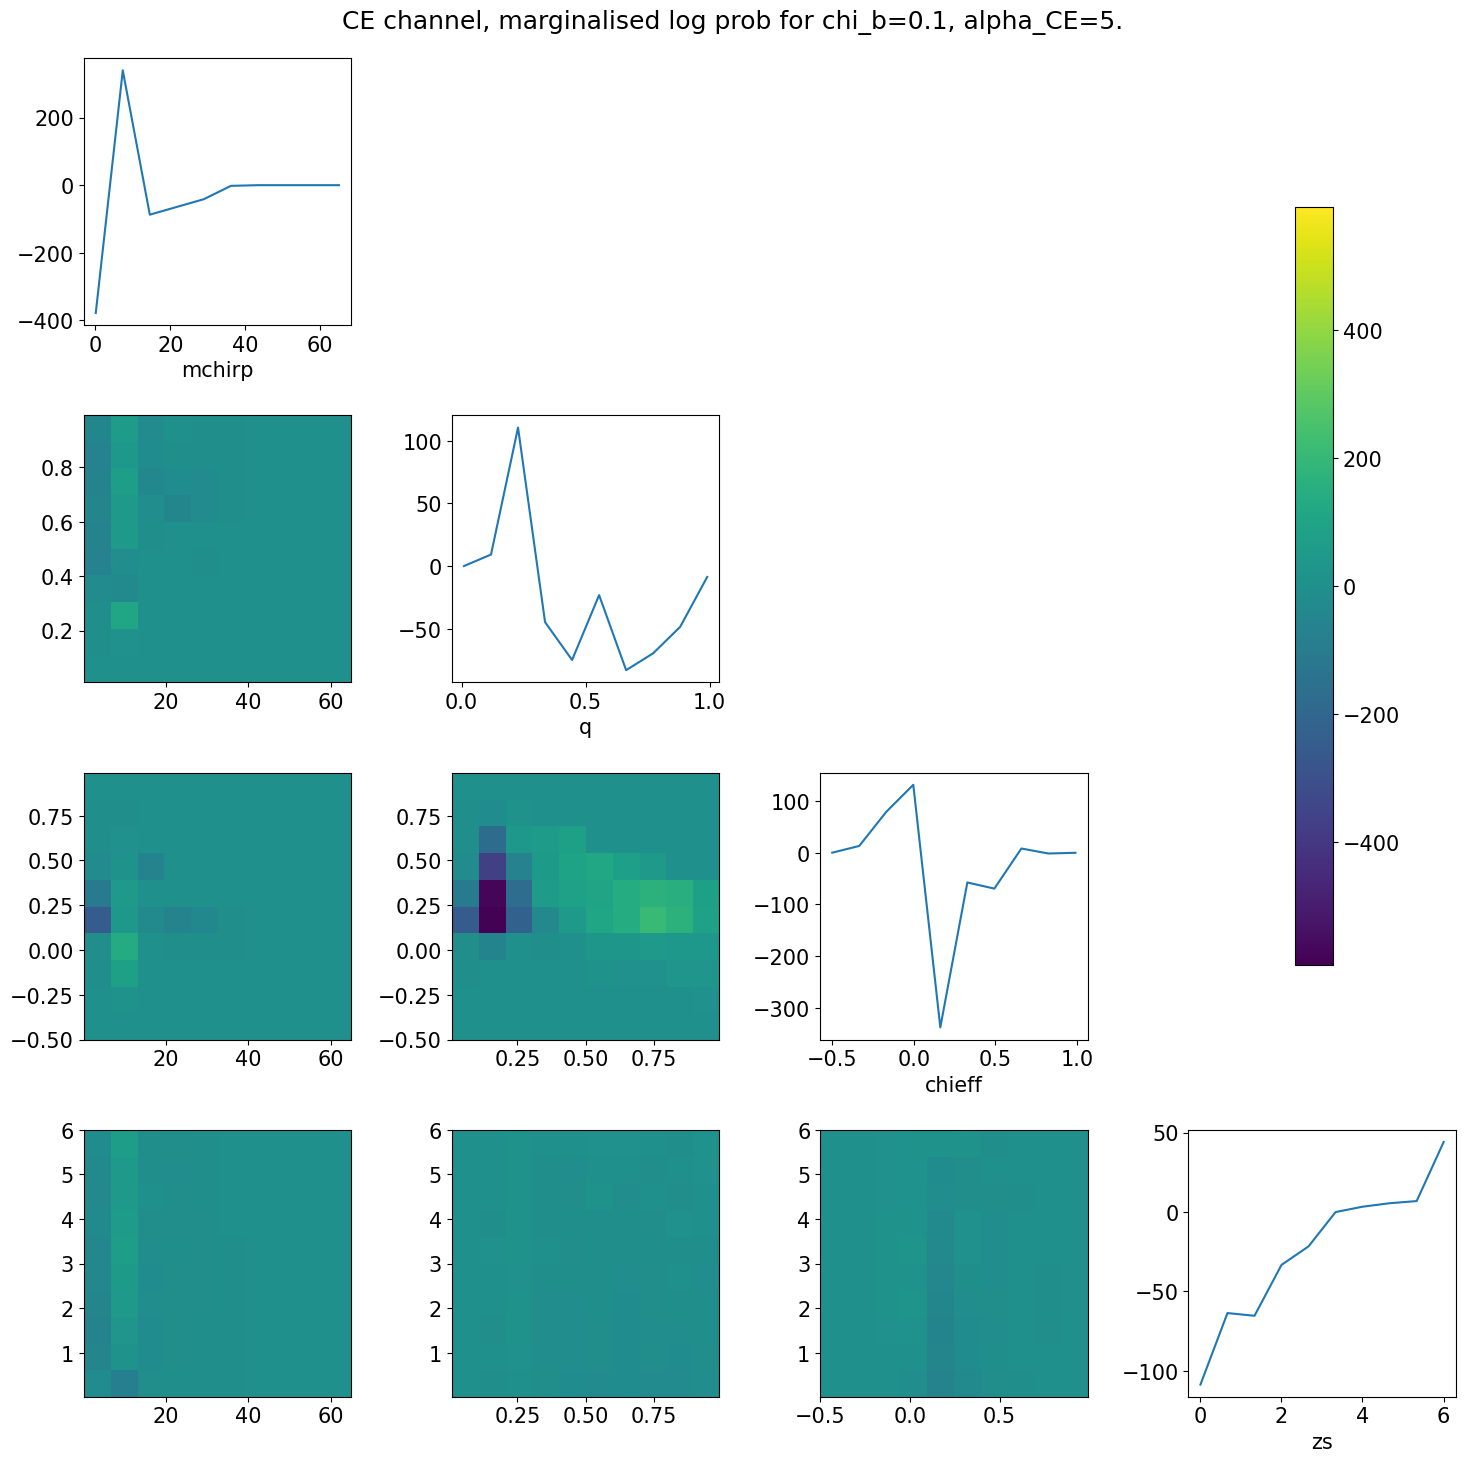

In [32]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig,ax=plt.subplots(4,4)
chibid = 1
channel_id=0


ratio_mchirpq_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(3,4))
ratio_mchirpchieff_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,4))
ratio_qchieff_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,4))
ratio_mchirpz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,3))
ratio_qz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,3))
ratio_chieffz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2))
ax[0,0].plot(mchirps, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,3,4))][0][chibid])
ax[0,0].set_xlabel('mchirp')
ax[1,1].plot(qs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,3,4))][0][chibid])
ax[1,1].set_xlabel('q')
ax[2,2].plot(chieffs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2,4))][0][chibid])
ax[2,2].set_xlabel('chieff')
ax[3,3].plot(zs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2,3))][0][chibid])
ax[3,3].set_xlabel('zs')

ax[0,1].set_axis_off()
ax[0,2].set_axis_off()
ax[1,2].set_axis_off()
ax[0,3].set_axis_off()
ax[1,3].set_axis_off()
ax[2,3].set_axis_off()

cbarmin=-np.min(ratio_qchieff_marg)

c = ax[1,0].imshow(np.swapaxes(ratio_mchirpq_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[2,0].imshow(np.swapaxes(ratio_mchirpchieff_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[2,1].imshow(np.swapaxes(ratio_qchieff_marg[chibid], 0,1), extent=(qs[0], qs[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,0].imshow(np.swapaxes(ratio_mchirpz_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[3,1].imshow(np.swapaxes(ratio_qz_marg[chibid], 0,1), extent=(qs[0], qs[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,2].imshow(np.swapaxes(ratio_chieffz_marg[chibid], 0,1), extent=(chieffs[0], chieffs[-1], zs[0], zs[-1], ), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')


cbar = fig.colorbar(c, ax=ax[:3,3], location='right')
fig.suptitle('CE channel, marginalised log prob for chi_b=0.1, alpha_CE=5.')
fig.tight_layout(pad=1.3)

#cbar = fig.colorbar(c, ax=ax[1,0])

In [68]:
np.shape(p_mchirpqchiz[channel_id,:,:,:,:,:])

(4, 10, 10, 10, 10)

/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_79975/1965913253.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1.3)


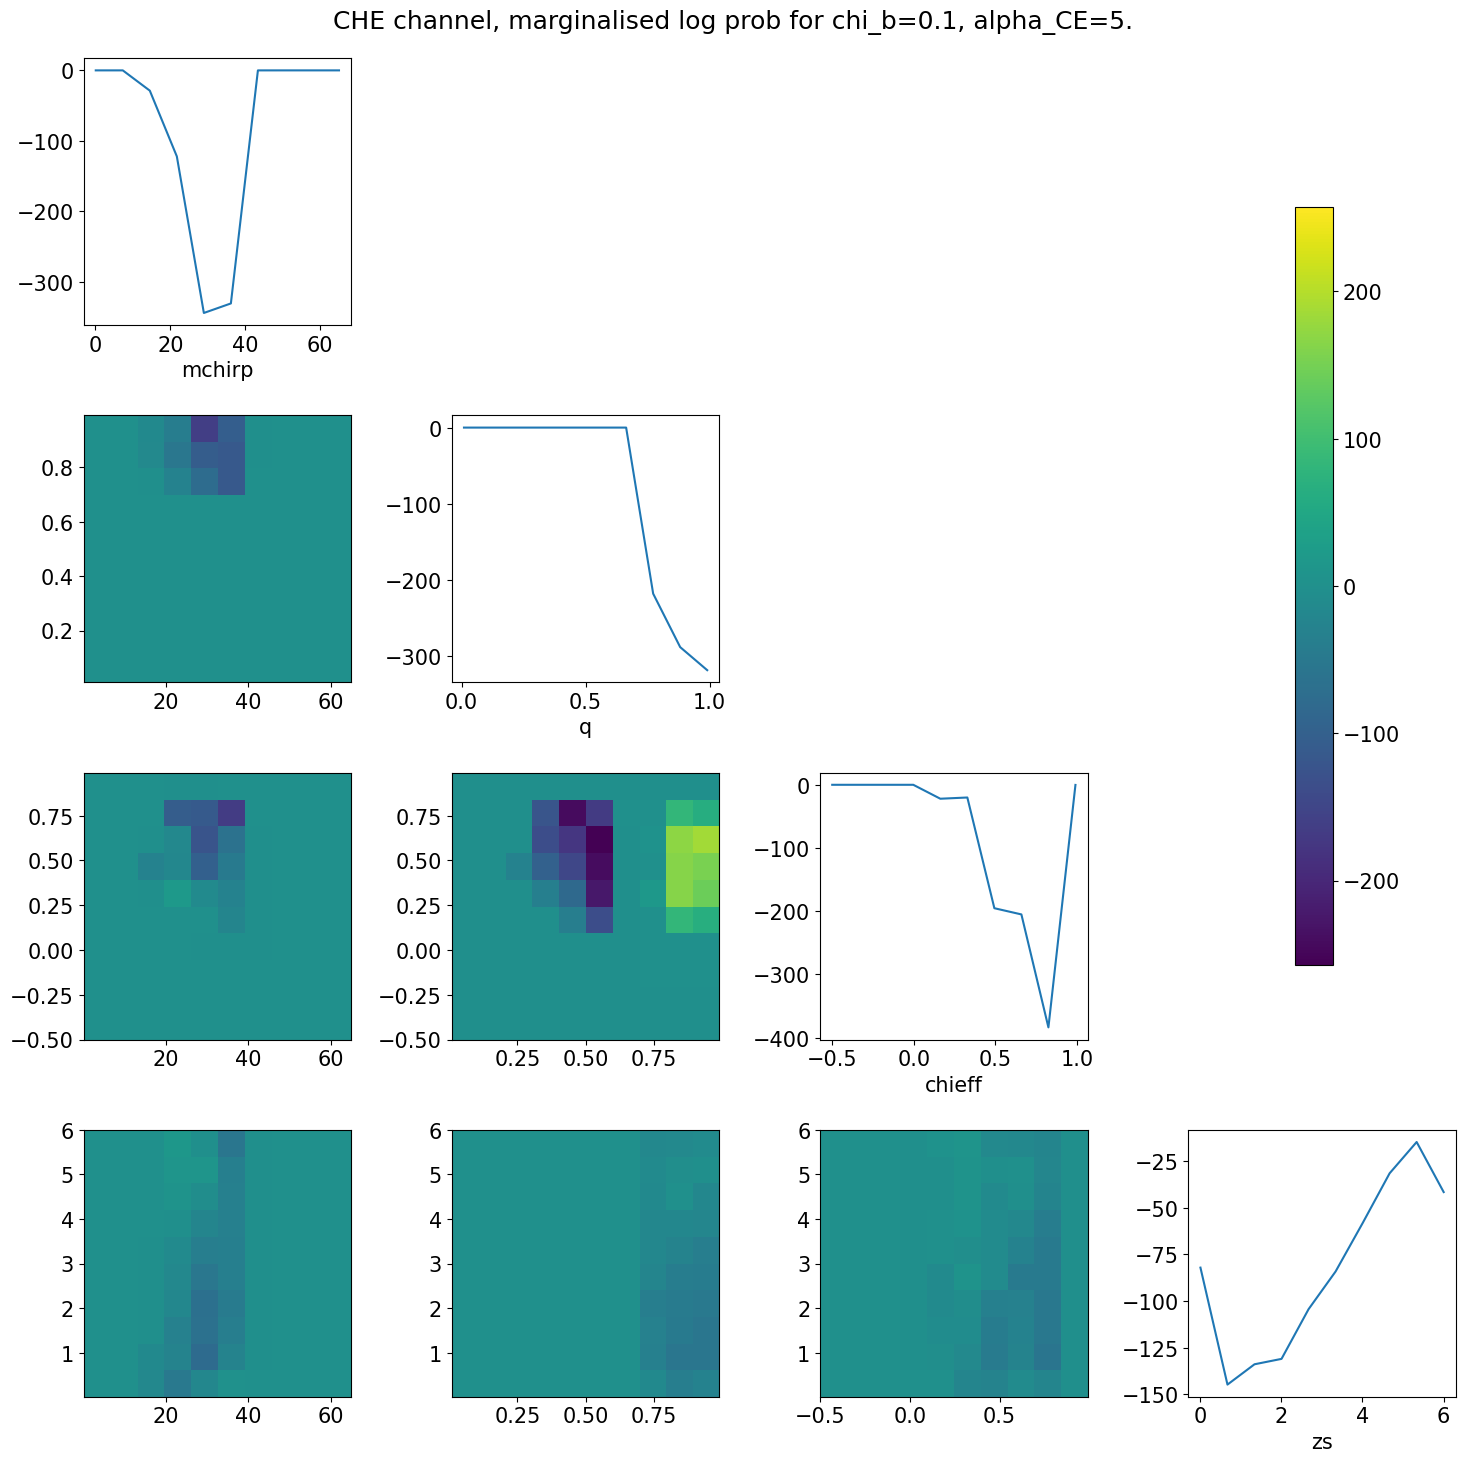

In [31]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig,ax=plt.subplots(4,4)
chibid = 1
channel_id=1


ratio_mchirpq_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(3,4))
ratio_mchirpchieff_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,4))
ratio_qchieff_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,4))
ratio_mchirpz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,3))
ratio_qz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,3))
ratio_chieffz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2))
ax[0,0].plot(mchirps, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,3,4))][0][chibid])
ax[0,0].set_xlabel('mchirp')
ax[1,1].plot(qs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,3,4))][0][chibid])
ax[1,1].set_xlabel('q')
ax[2,2].plot(chieffs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2,4))][0][chibid])
ax[2,2].set_xlabel('chieff')
ax[3,3].plot(zs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2,3))][0][chibid])
ax[3,3].set_xlabel('zs')

ax[0,1].set_axis_off()
ax[0,2].set_axis_off()
ax[1,2].set_axis_off()
ax[0,3].set_axis_off()
ax[1,3].set_axis_off()
ax[2,3].set_axis_off()

cbarmin=-np.min(ratio_qchieff_marg)

c = ax[1,0].imshow(np.swapaxes(ratio_mchirpq_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[2,0].imshow(np.swapaxes(ratio_mchirpchieff_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[2,1].imshow(np.swapaxes(ratio_qchieff_marg[chibid], 0,1), extent=(qs[0], qs[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,0].imshow(np.swapaxes(ratio_mchirpz_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[3,1].imshow(np.swapaxes(ratio_qz_marg[chibid], 0,1), extent=(qs[0], qs[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,2].imshow(np.swapaxes(ratio_chieffz_marg[chibid], 0,1), extent=(chieffs[0], chieffs[-1], zs[0], zs[-1], ), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')


cbar = fig.colorbar(c, ax=ax[:3,3], location='right')
fig.suptitle('CHE channel, marginalised log prob for chi_b=0.1, alpha_CE=5.')
fig.tight_layout(pad=1.3)

#cbar = fig.colorbar(c, ax=ax[1,0])

/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_79975/4060013825.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1.3)


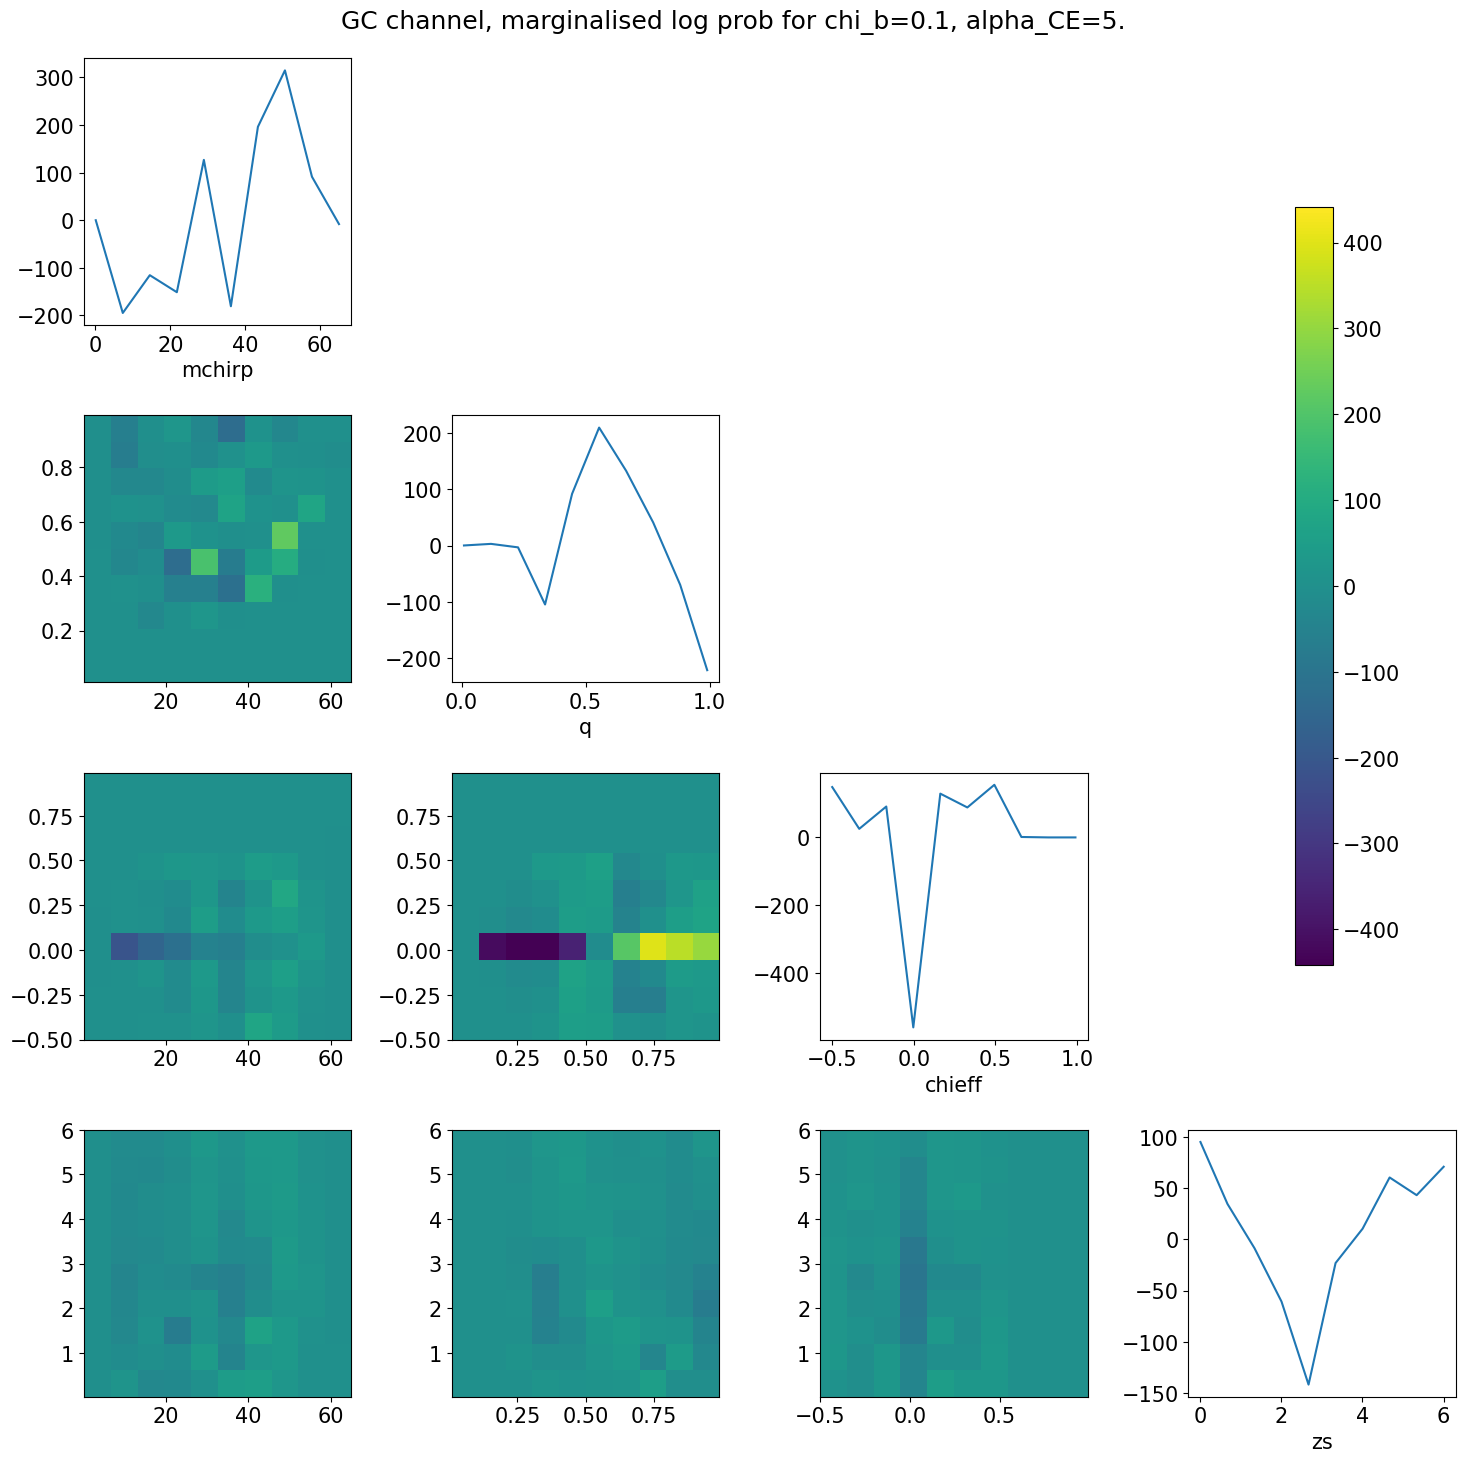

In [29]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig,ax=plt.subplots(4,4)
chibid = 1
channel_id=2


ratio_mchirpq_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(3,4))
ratio_mchirpchieff_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,4))
ratio_qchieff_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,4))
ratio_mchirpz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,3))
ratio_qz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,3))
ratio_chieffz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2))
ax[0,0].plot(mchirps, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,3,4))][0][chibid])
ax[0,0].set_xlabel('mchirp')
ax[1,1].plot(qs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,3,4))][0][chibid])
ax[1,1].set_xlabel('q')
ax[2,2].plot(chieffs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2,4))][0][chibid])
ax[2,2].set_xlabel('chieff')
ax[3,3].plot(zs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2,3))][0][chibid])
ax[3,3].set_xlabel('zs')

ax[0,1].set_axis_off()
ax[0,2].set_axis_off()
ax[1,2].set_axis_off()
ax[0,3].set_axis_off()
ax[1,3].set_axis_off()
ax[2,3].set_axis_off()

cbarmin=np.max(ratio_qchieff_marg)

c = ax[1,0].imshow(np.swapaxes(ratio_mchirpq_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[2,0].imshow(np.swapaxes(ratio_mchirpchieff_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[2,1].imshow(np.swapaxes(ratio_qchieff_marg[chibid], 0,1), extent=(qs[0], qs[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,0].imshow(np.swapaxes(ratio_mchirpz_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[3,1].imshow(np.swapaxes(ratio_qz_marg[chibid], 0,1), extent=(qs[0], qs[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,2].imshow(np.swapaxes(ratio_chieffz_marg[chibid], 0,1), extent=(chieffs[0], chieffs[-1], zs[0], zs[-1], ), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')


cbar = fig.colorbar(c, ax=ax[:3,3], location='right')
fig.suptitle('GC channel, marginalised log prob for chi_b=0.1, alpha_CE=5.')
fig.tight_layout(pad=1.3)

#cbar = fig.colorbar(c, ax=ax[1,0])

/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_79975/1302080716.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1.3)


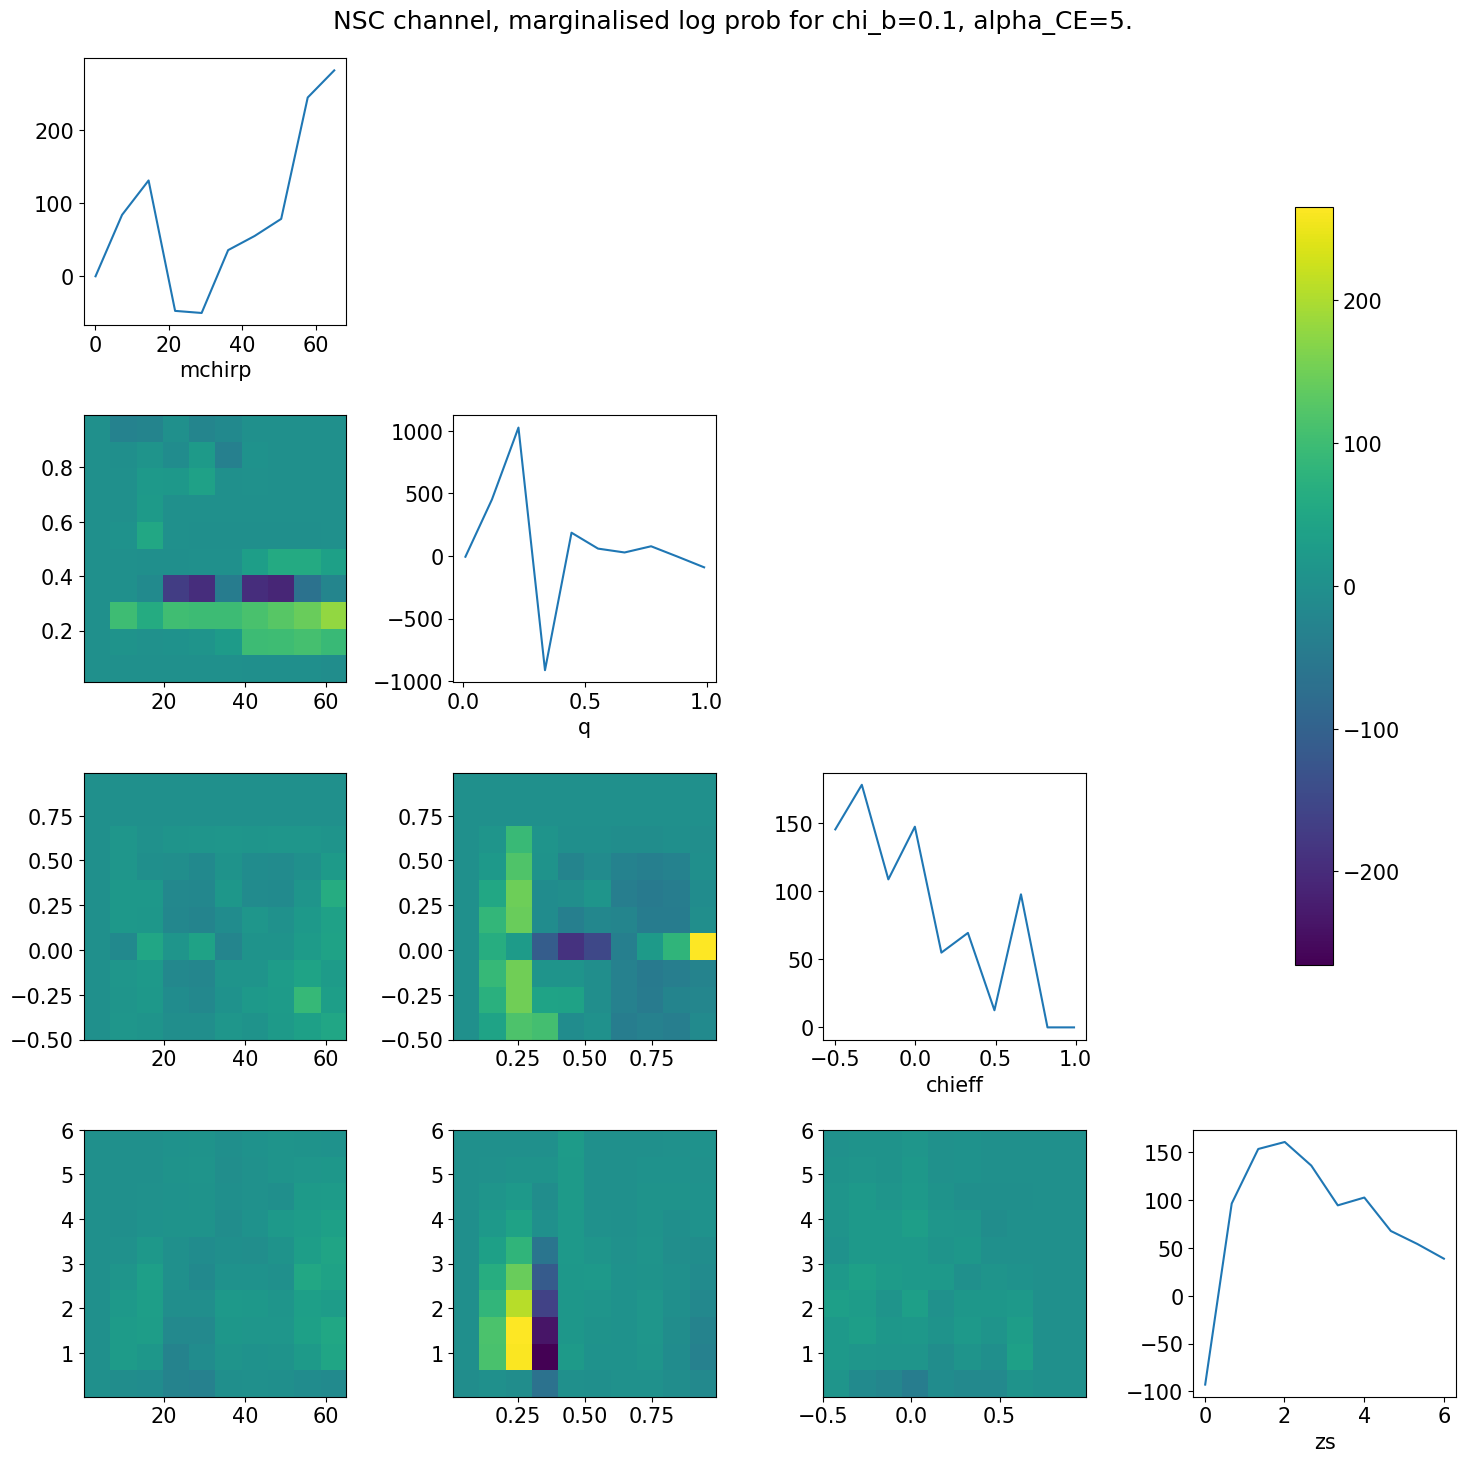

In [47]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig,ax=plt.subplots(4,4)
chibid = 1
channel_id=3


ratio_mchirpq_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(3,4))
ratio_mchirpchieff_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,4))
ratio_qchieff_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,4))
ratio_mchirpz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,3))
ratio_qz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,3))
ratio_chieffz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2))
ax[0,0].plot(mchirps, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,3,4))][0][chibid])
ax[0,0].set_xlabel('mchirp')
ax[1,1].plot(qs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,3,4))][0][chibid])
ax[1,1].set_xlabel('q')
ax[2,2].plot(chieffs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2,4))][0][chibid])
ax[2,2].set_xlabel('chieff')
ax[3,3].plot(zs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2,3))][0][chibid])
ax[3,3].set_xlabel('zs')

ax[0,1].set_axis_off()
ax[0,2].set_axis_off()
ax[1,2].set_axis_off()
ax[0,3].set_axis_off()
ax[1,3].set_axis_off()
ax[2,3].set_axis_off()

cbarmin=np.max(ratio_qz_marg[chibid])

c = ax[1,0].imshow(np.swapaxes(ratio_mchirpq_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[2,0].imshow(np.swapaxes(ratio_mchirpchieff_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[2,1].imshow(np.swapaxes(ratio_qchieff_marg[chibid], 0,1), extent=(qs[0], qs[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,0].imshow(np.swapaxes(ratio_mchirpz_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[3,1].imshow(np.swapaxes(ratio_qz_marg[chibid], 0,1), extent=(qs[0], qs[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,2].imshow(np.swapaxes(ratio_chieffz_marg[chibid], 0,1), extent=(chieffs[0], chieffs[-1], zs[0], zs[-1], ), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')


cbar = fig.colorbar(c, ax=ax[:3,3], location='right')
fig.suptitle('NSC channel, marginalised log prob for chi_b=0.1, alpha_CE=5.')
fig.tight_layout(pad=1.3)

#cbar = fig.colorbar(c, ax=ax[1,0])

/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_79975/76952475.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1.3)


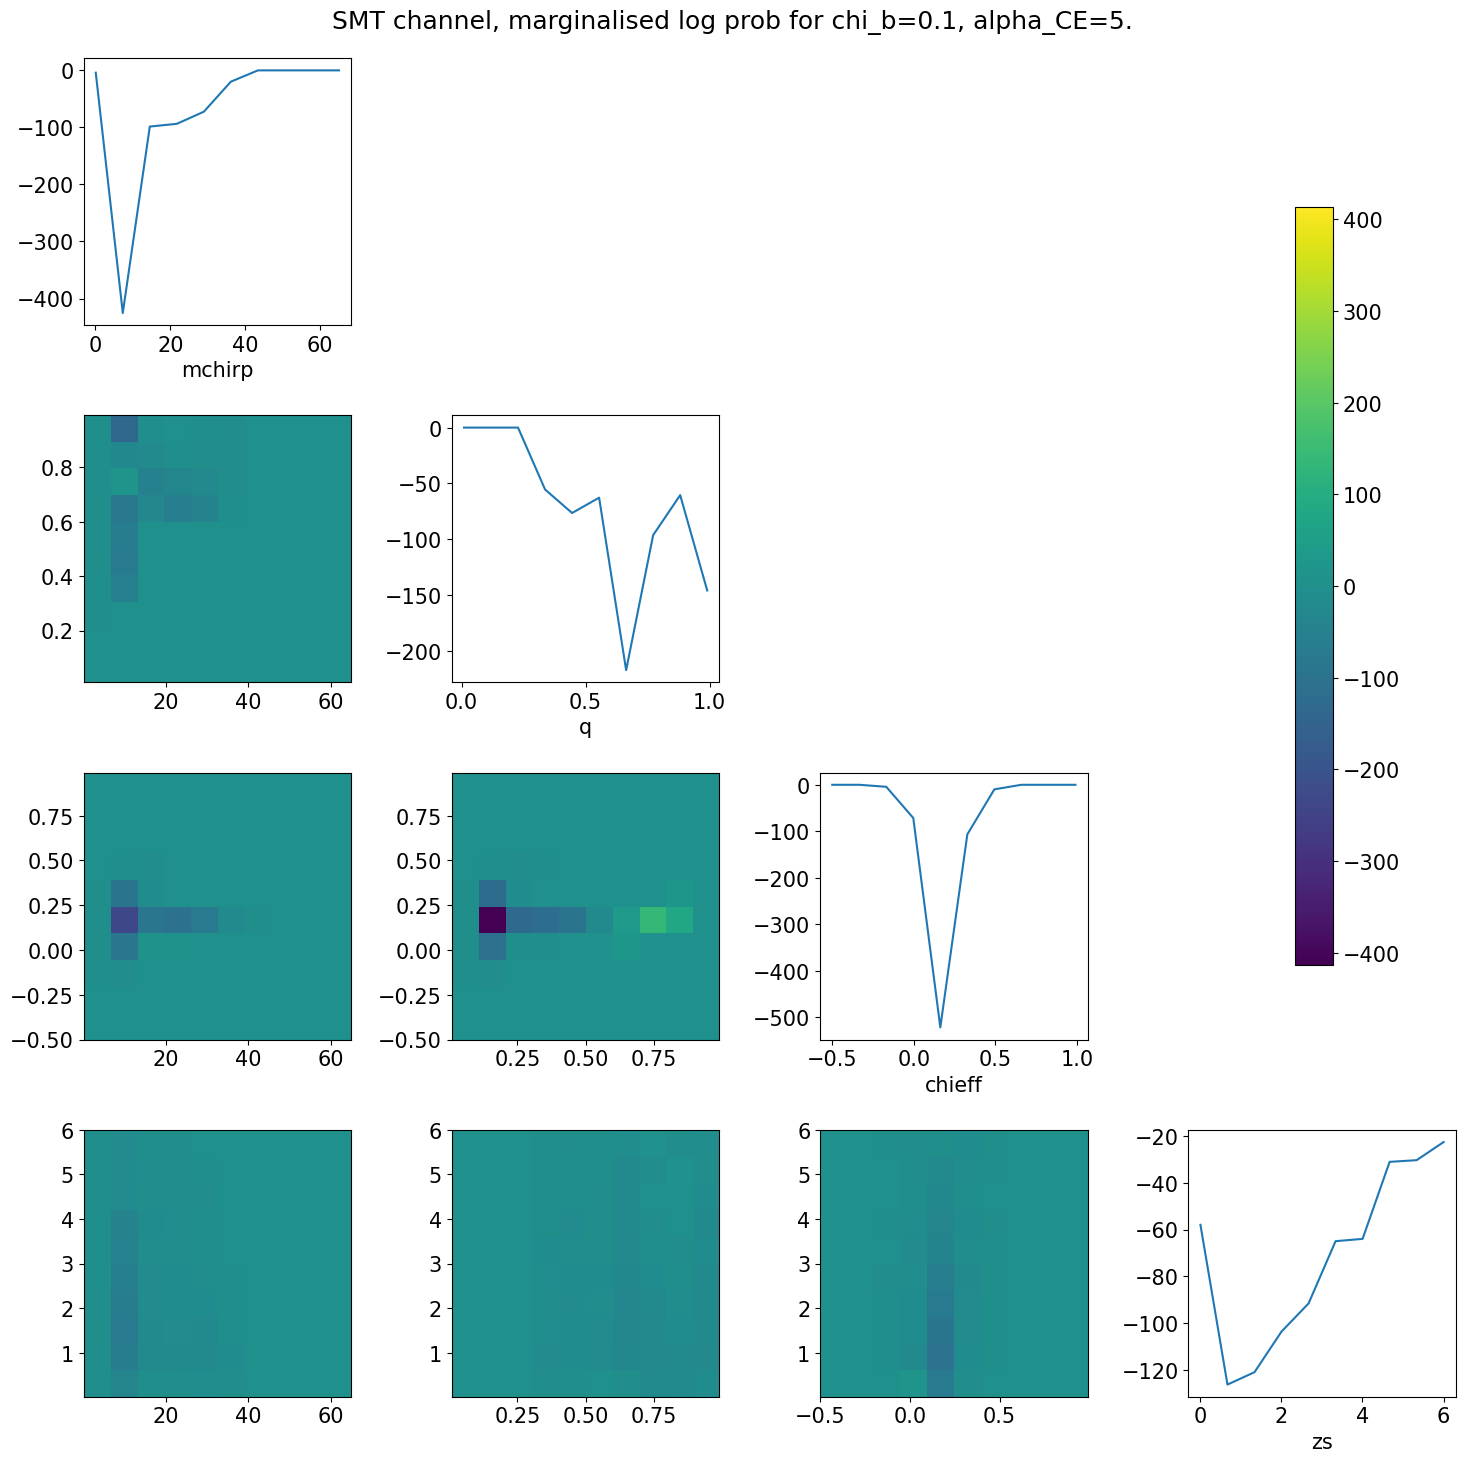

In [46]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig,ax=plt.subplots(4,4)
chibid = 1
channel_id=4


ratio_mchirpq_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(3,4))
ratio_mchirpchieff_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,4))
ratio_qchieff_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,4))
ratio_mchirpz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,3))
ratio_qz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,3))
ratio_chieffz_marg = np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2))
ax[0,0].plot(mchirps, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(2,3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(2,3,4))][0][chibid])
ax[0,0].set_xlabel('mchirp')
ax[1,1].plot(qs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,3,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,3,4))][0][chibid])
ax[1,1].set_xlabel('q')
ax[2,2].plot(chieffs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2,4)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2,4))][0][chibid])
ax[2,2].set_xlabel('chieff')
ax[3,3].plot(zs, [np.sum(p_mchirpqchiz[channel_id,:,:,:,:,:], axis=(1,2,3)) - np.sum(p_mchirpqchiz_kde[channel_id,:,:,:,:,:], axis=(1,2,3))][0][chibid])
ax[3,3].set_xlabel('zs')

ax[0,1].set_axis_off()
ax[0,2].set_axis_off()
ax[1,2].set_axis_off()
ax[0,3].set_axis_off()
ax[1,3].set_axis_off()
ax[2,3].set_axis_off()

cbarmin=-np.min(ratio_qchieff_marg[chibid])

c = ax[1,0].imshow(np.swapaxes(ratio_mchirpq_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[2,0].imshow(np.swapaxes(ratio_mchirpchieff_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[2,1].imshow(np.swapaxes(ratio_qchieff_marg[chibid], 0,1), extent=(qs[0], qs[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,0].imshow(np.swapaxes(ratio_mchirpz_marg[chibid], 0,1), extent=(mchirps[0], mchirps[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[3,1].imshow(np.swapaxes(ratio_qz_marg[chibid], 0,1), extent=(qs[0], qs[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,2].imshow(np.swapaxes(ratio_chieffz_marg[chibid], 0,1), extent=(chieffs[0], chieffs[-1], zs[0], zs[-1], ), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')

cbar = fig.colorbar(c, ax=ax[:3,3], location='right')
fig.suptitle('SMT channel, marginalised log prob for chi_b=0.1, alpha_CE=5.')
fig.tight_layout(pad=1.3)

#cbar = fig.colorbar(c, ax=ax[1,0])

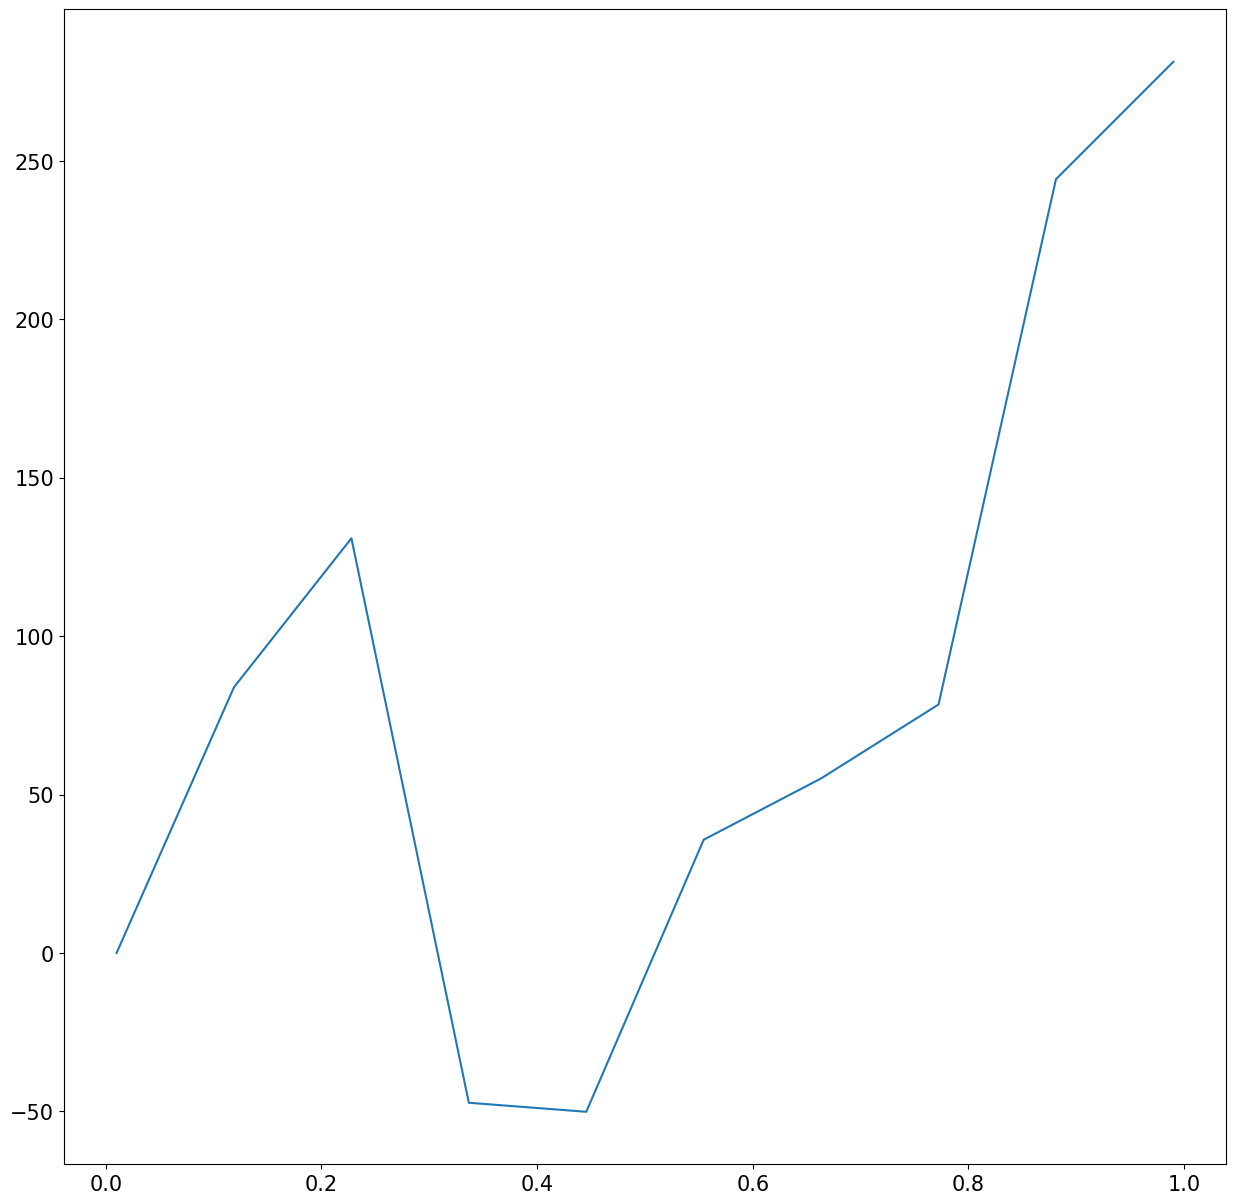

In [50]:
plt.plot(qs, np.sum(ratio_mchirpq_marg[chibid], axis=1))